In [2]:
#Connecting Google Drive with Google Colab to load the model from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#TO import data from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
#to authenticate google drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
#Bring file in /content/ from google drive
downloaded = drive.CreateFile({'id':"1a3p1KL3egwoR76t90PaMdtszh_USRoPq"})   # replace the id with id of file you want to access
downloaded.GetContentFile('Final-Updated-stanford-car-dataset-by-classes-folder.zip')        # replace the file name with your file

In [6]:
#import os
#os.environ['KAGGLE_USERNAME'] = "muhammadsafwan" # username from the json file
#os.environ['KAGGLE_KEY'] = "54baf031d17e8d10d150668cdbeca660" # key from the json file
#!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder # api copied from kaggle

In [7]:
#Unzipping the files
!unzip -q "/content/Final-Updated-stanford-car-dataset-by-classes-folder.zip"
#!unzip '/content/stanford-car-dataset-by-classes-folder.zip'


replace Final-Updated-stanford-car-dataset-by-classes-folder/anno_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Final-Updated-stanford-car-dataset-by-classes-folder/anno_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import confusion_matrix
import os

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):

    #checkpoint = torch.load(filepath,map_location='cpu') #unka
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model = models.resnet34(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 150)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model


In [20]:
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.ToTensor(),])
test_dir = '/content/Final-Updated-stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_dataset =  datasets.ImageFolder(test_dir,transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [21]:
def Cal_Accuracy(model):
  correct = 0
  total = 0
  model = model.to(device)
  predlist=torch.zeros(0,dtype=torch.long,device=device)
  lbllist=torch.zeros(0,dtype=torch.long,device=device)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted_outcome.view(-1)])
        lbllist=torch.cat([lbllist,labels.view(-1)])

  conf_mat=confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy())
  Acc = round(100 * correct / total,3)
  return Acc, conf_mat

In [22]:
model_name = "modelFinal"
path = "/content/drive/My Drive/Colab Notebooks/model/"+model_name+".pth"
model = load_checkpoint(path)
accuracy , matrix = (Cal_Accuracy(model))
print("Accuracy:",accuracy,"%")
print("matrix")

Accuracy: 88.259 %
matrix


In [23]:
class_accuracy=(100*matrix.diagonal()/matrix.sum(1)).round(2)
class_acc = dict(zip(test_dataset.classes,class_accuracy))
class_acc = sorted(class_acc.items(), key=lambda x: x[1])    


for i in range(150):
  print(class_acc[i][0],"accuracy is:",class_acc[i][1],"%")



Acura TSX Sedan 2012 accuracy is: 60.0 %
Chevrolet Express Van 2007 accuracy is: 61.11 %
Audi S5 Convertible 2012 accuracy is: 61.9 %
Hyundai Azera Sedan 2012 accuracy is: 61.9 %
Audi S4 Sedan 2007 accuracy is: 65.22 %
Suzuki Aerio Sedan 2007 accuracy is: 68.42 %
GMC Canyon Extended Cab 2012 accuracy is: 70.0 %
Mitsubishi Lancer Sedan 2012 accuracy is: 70.83 %
Bentley Mulsanne Sedan 2011 accuracy is: 72.22 %
Dodge Dakota Club Cab 2007 accuracy is: 73.68 %
Acura ZDX Hatchback 2012 accuracy is: 75.0 %
Isuzu Ascender SUV 2008 accuracy is: 75.0 %
Chevrolet Corvette Convertible 2012 accuracy is: 76.19 %
GMC Acadia SUV 2012 accuracy is: 77.27 %
Volkswagen Golf Hatchback 2012 accuracy is: 77.27 %
Volvo XC90 SUV 2007 accuracy is: 77.27 %
Audi RS 4 Convertible 2008 accuracy is: 77.78 %
Mazda Tribute SUV 2011 accuracy is: 77.78 %
Mercedes-Benz SL-Class Coupe 2009 accuracy is: 77.78 %
Eagle Talon Hatchback 1998 accuracy is: 78.26 %
Suzuki Kizashi Sedan 2012 accuracy is: 78.26 %
Aston Martin Virag

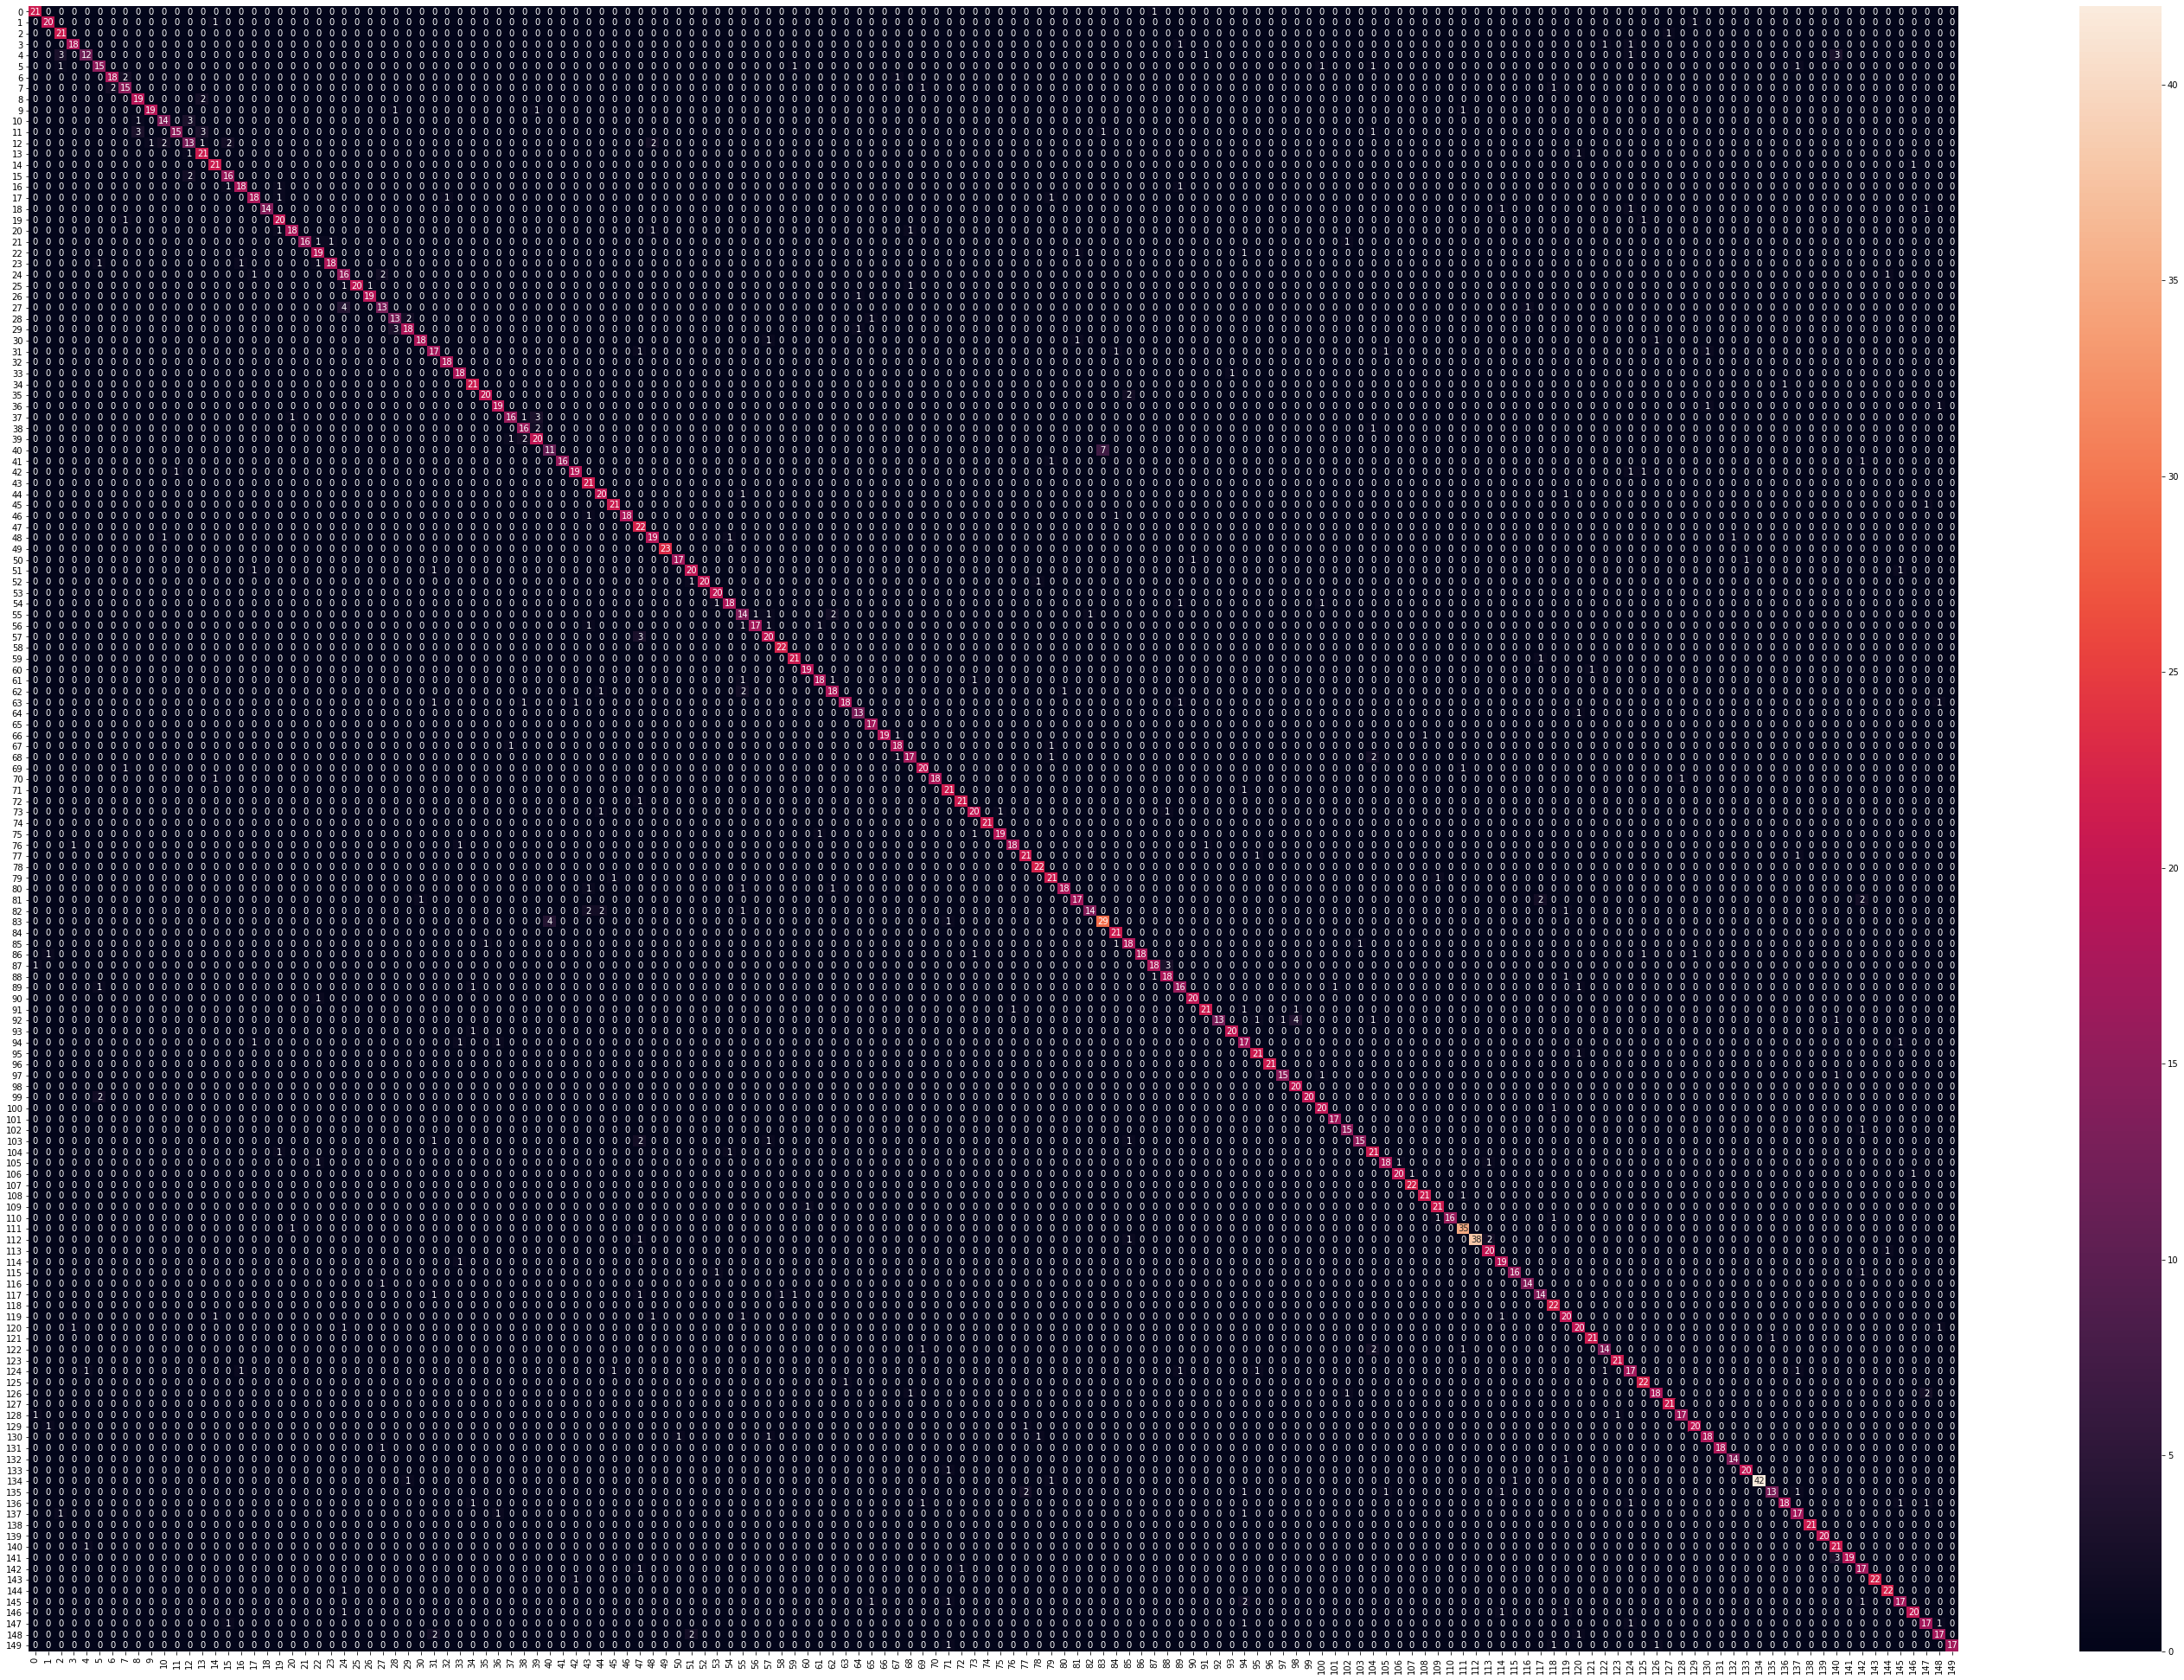

In [24]:
df_cm = pd.DataFrame(matrix,range(150), range(150))
plt.figure(figsize = (50,35))
sn.heatmap(df_cm, annot=True)